In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
from dune.grid import cartesianDomain
from dune.grid import yaspGrid
from dune.alugrid import aluConformGrid
#from dune.grid import reader
#from dune. import gmsh2DGF
#from dune.fem.utility import gridWidth
from dune.fem.function import gridFunction
#import pygmsh

# Task 3
Write a class `LinearLagrangeSpace`

In [2]:
class LinearLagrangeSpace:
    def __init__(self,view):
        self.view = view
        # Create a mapper for the vertex indices
        self.mapper = self.view.mapper(lambda gt: 1 if gt.dim==0 else 0)
        self.localDofs = 3
        self.points = np.array( [ [0,0],[1,0],[0,1] ] )
    def evaluateLocal(self, x):
        # Return a numpy array with the evaluations
        # of the 3 basis functions at local point x
        return np.array([1-x[0]-x[1], x[0], x[1]])
    def gradientLocal(self, x):
        # Return a numpy array with the evaluations
        # of the gradients of the 3 basis functions in local point x
        # return np.array( dbary )
        return np.array([np.array([-1., -1]), np.array([1., 0]), np.array([0., 1])])

In [45]:
#domain = cartesianDomain([-.5, -.5], [2, 1], [10, 20])
domain = cartesianDomain([0, 0], [1, 1], [10, 10])
barycenter = np.array([1./3, 1/3])
gridView = aluConformGrid(domain)
space = LinearLagrangeSpace(gridView)
print(f"This map has {space.mapper.size} degrees of freedom")
print(f"This view has {space.view.size(2)} vertices")
print(f"Bases at [1/3, 1/3]: {space.evaluateLocal(np.array([1./3, 1/3]))}")
print(f"With gradients: {space.gradientLocal(np.array([1./3, 1/3]))}")
print(f"There are {space.view.size(0)} elements")
e0, e1 = [e for e in space.view.elements][:2]
print(e0.geometry.integrationElement(barycenter))
print(e0.geometry.integrationElement([0, 0]))
print(np.linalg.det(e0.geometry.jacobian(barycenter)))
print(e0.geometry.jacobianInverseTransposed(barycenter))
print(np.linalg.det(e0.geometry.jacobianInverseTransposed(barycenter)))
print(e0.geometry.jacobianInverseTransposed(np.array([0, 0])))

This map has 121 degrees of freedom
This view has 121 vertices
Bases at [1/3, 1/3]: [0.33333333 0.33333333 0.33333333]
With gradients: [[-1. -1.]
 [ 1.  0.]
 [ 0.  1.]]
There are 200 elements
0.010000000000000002
0.010000000000000002
-0.010000000000000004
((10.000000, -10.000000) 
(-10.000000, -0.000000) )
-100.00000000000004
((10.000000, -10.000000) 
(-10.000000, -0.000000) )


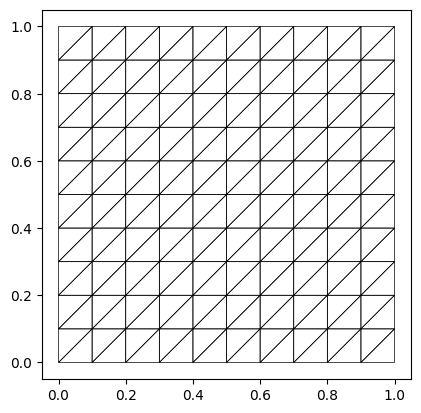

In [10]:
gridView.plot()

In [25]:
print(dir(e0.geometry))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_includes', '_typeName', 'affine', 'center', 'corner', 'corners', 'cppIncludes', 'cppTypeName', 'integrationElement', 'jacobian', 'jacobianInverse', 'jacobianInverseTransposed', 'jacobianTransposed', 'pushForwardGradients', 'referenceElement', 'toGlobal', 'toLocal', 'volume']


In [37]:
e0.geometry.toGlobal(barycenter)

Dune::FieldVector<2>(-0.416667, -0.450000)

# Task 4
Here we do the actual assembly of the mass matrix and rhs vector b. We assemble a local mass matrix $M^E$ and vector $b^E$ by inserting the interpolation of $u_h$ over the basis functions $\phi_i$. The computation of $b_l^E$ can be done in global coordinates as
$$b_l^E=\int_E u(x)\hat{\phi}_l(F_E^{-1}(x)dx)$$
We approximate the integral by a midpoint rule quadrature, so we get
$$b_l^E\approx u(S_d)\hat{\phi}_l(F_E^{-1}(S_d))|E|$$
where $|E|$ is the area of the element $E$ and $S_d$ is the barycenter of the triangle, from the midpoint quadrature.

Similarly, $M^E_{kl}$ becomes
$$M^E_{kl}\approx \hat{\phi}_k(\hat{S}_d)\hat{\phi}_l(\hat{S}_d)|DF||\hat{E}|$$
where $|\hat{E}|$ is the area of the reference element $\hat{E}$ and $\hat{S}_d$ is the barycenter of the reference triangle, from the midpoint quadrature. Here, since we integrated in local coordinates, we need the determinant of the Jacobian of the transformation $F_E:\hat{E}\rightarrow E$, denoted $|DF|$.

In this way, the local mass matrix is a 3x3 matrix and the local rhs vector a length three vector. The contributions are then stored in COO sparse format and converted into an NxN global CSR matrix.

In [139]:
print(space.mapper.subIndices(e0, 2))
print(space.mapper.subIndices(e1, 2))
print([v.geometry.center for v in e0.vertices])

(0, 1, 2)
(2, 3, 0)
[Dune::FieldVector<2>(0.000000, 0.000000), Dune::FieldVector<2>(0.000000, 1.000000), Dune::FieldVector<2>(1.000000, 1.000000)]


In [31]:
def assemble(space,force):
    # storage for right hand side
    rhs = np.zeros(len(space.mapper))
    # storage for local matrix
    localEntries = space.localDofs
    localMatrix = np.zeros([localEntries,localEntries])
    # data structure for global matrix using coordinate (COO) format
    globalEntries = localEntries**2 * space.view.size(0)
    value = np.zeros(globalEntries)
    rowIndex, colIndex = np.zeros(globalEntries,int), np.zeros(globalEntries,int)

    # Assembly of matrix and forcing term
    # Iterate through elements, computing the local matrix and b vector
    # Note that the toGlobal function is F_E: E_local -> E
    barycenter = np.array([1./3, 1/3]) # local barycenter
    for E_ind, E in enumerate(space.view.elements):
        # Evaluate basis fcns at barycenter
        basis_bary = space.evaluateLocal(barycenter)
        # Integration element
        DF = E.geometry.integrationElement(barycenter)
        # Area of reference element (1/2)
        area = E.geometry.referenceElement.volume
        # Assemble local mass matrix
        for l in range(localEntries):
            for k in range(localEntries):
                # M_kl=M[l, k] = phi_k(bary)*phi_l(bary)*DF*|E_local|
                localMatrix[l, k] = basis_bary[k]*basis_bary[l]
        # Multiply by DF and area
        #print(f"Local matrix before mult:\n{localMatrix}")
        localMatrix *= DF*area
        # Try with exact local matrix
        #localMatrix = (DF*area/12)*(np.ones((3, 3))+np.identity(3))
        #print(f"Local matrix after mult:\n{localMatrix}")
        # Add these local matrix elements into the global value, row, col vectors
        # Each element will be identified by its global index and then have 9
        # consecutive values after that starting index given
        # by start+3l+k. These correspond to values associated with the global
        # index of g_E(l) and g_E(k) for vertices l and k. The global matrix
        # has NxN entries and the one matching M^E_kl should be row g_E(l)
        # and col g_E(k)
        # Get global indices of vertices
        index_arr = np.array(space.mapper.subIndices(E, codim=2))
        # Start index for this element, localEntries**2 * E_ind
        # so we can store 9 consecutive elements without overlapping
        start_ind = localEntries**2 * E_ind
        for l in range(localEntries):
            for k in range(localEntries):
                # M_kl
                value[start_ind+3*l+k] = localMatrix[l, k]
                # With row ind g_E(l), col index g_E(k)
                rowIndex[start_ind+3*l+k] = index_arr[l]
                colIndex[start_ind+3*l+k] = index_arr[k]
        # Multiply each basis fcn by the force at center
        # and area of element
        # b_E is rhs vector on element E
        #print(E.geometry.toGlobal(barycenter), force(E.geometry.toGlobal(barycenter)))
        #print(f"Basis: {basis_bary}")
        #print(f"Vol: {E.geometry.volume}")
        b_E = force(E.geometry.toGlobal(barycenter))*E.geometry.volume*basis_bary
        #print(f"Result:{b_E}")
        # Increment values in rhs at the vertex indices
        #print(f"Incrementing indices:{index_arr}")
        rhs[index_arr] += b_E
    
    # convert data structure to compressed row storage (csr)
    #print(rowIndex)
    matrix = scipy.sparse.coo_matrix((value, (rowIndex, colIndex)), shape=(len(space.mapper),len(space.mapper))).tocsr()
    return rhs,matrix

121
(121, 121)


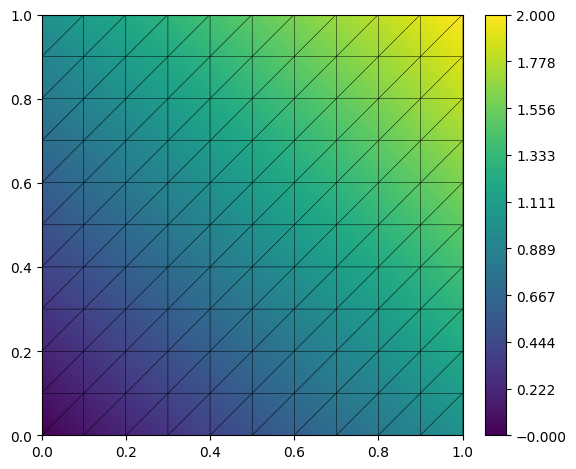

In [25]:
# Testing assemble
@gridFunction(gridView, name="Test", order=3)
def test(x):
    #return np.array([x[0]**2+x[1]])
    return np.sum(x)
b, M = assemble(space, test)
print(len(b))
#print(b)
print(M.shape)
#print(M.todense())
test.plot()


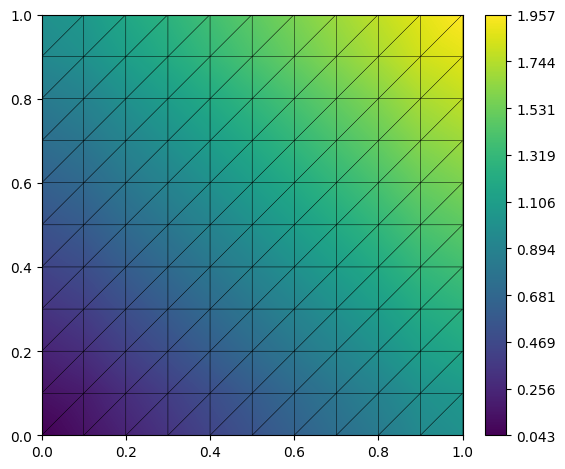

In [26]:
# If we solve this system, we should get the values of the projection
# on each vertex
dofs = scipy.sparse.linalg.spsolve(M, b)
# Then u_h is the interpolation of these values across each local element
@gridFunction(gridView, name="Projection Test", order=1)
def u_h_test(e, x):
    # On element e, we have local basis fcns from space
    # and values at the vertices in the dofs vector
    index_arr = np.array(space.mapper.subIndices(e, codim=2))
    vertex_vals = dofs[index_arr]
    basis_vals = space.evaluateLocal(x)
    return np.dot(vertex_vals, basis_vals)
u_h_test.plot()

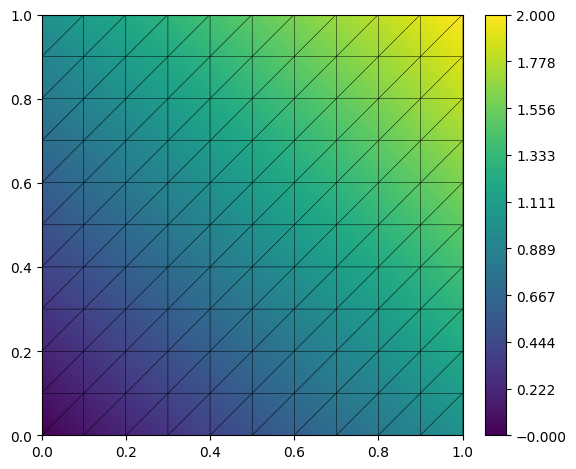

In [7]:
# Is this right? Try doing the same with the built in lagrange space
from dune.fem.space import lagrange
space_fem = lagrange(gridView, order=2)
u_h_fem = space_fem.interpolate(test, name='u_h fem test')
u_h_fem.plot()

Next we test this on a grid function to see if we can get the finite element projection of it on our Lagrange space.

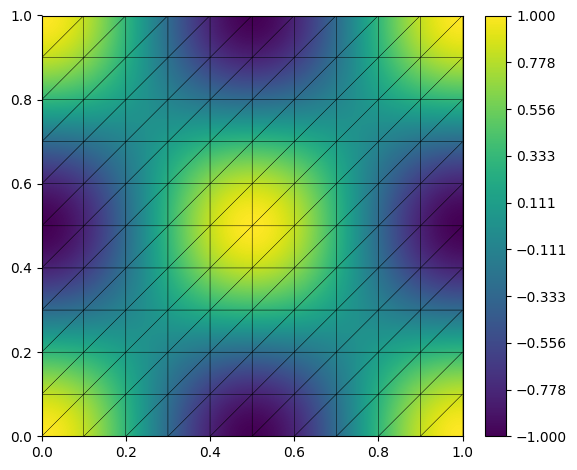

number of elements: 200 number of dofs: 121


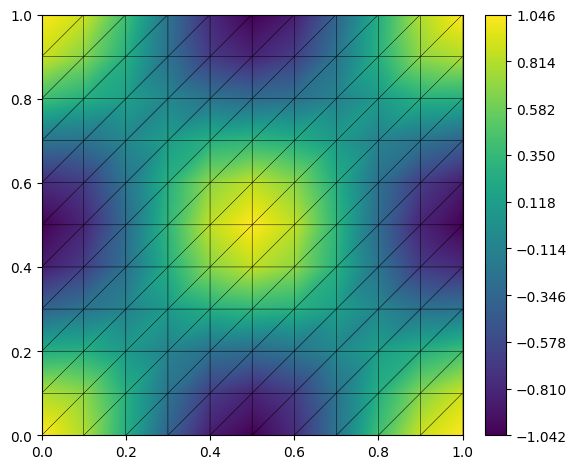

number of elements: 800 number of dofs: 441


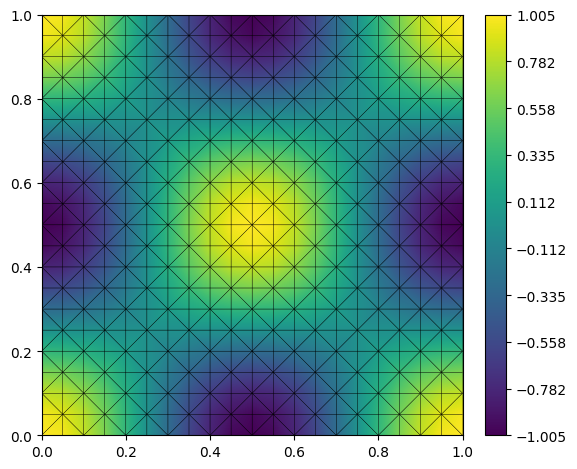

number of elements: 3200 number of dofs: 1681


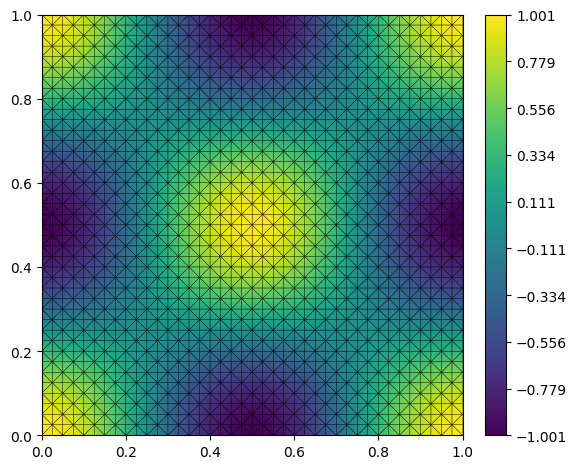

In [27]:
# First construct the grid
domain = cartesianDomain([0, 0], [1, 1], [10, 10])
view = aluConformGrid(domain)
# then the grid function to project
@gridFunction(view, name="u_ex", order=3)
def u(p):
    x,y = p
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)
u.plot(level=3)
# and then do the projection on a series of globally refined grids
for ref in range(3):
    space = LinearLagrangeSpace(view)
    print("number of elements:",view.size(0),"number of dofs:",len(space.mapper))
    rhs,matrix = assemble(space, u)
    dofs = scipy.sparse.linalg.spsolve(matrix,rhs)
    @gridFunction(view, name="u_h", order=1)
    def uh(e,x):
        indices = space.mapper(e)
        phiVals = space.evaluateLocal(x)
        localDofs = dofs[indices]
        return np.dot(localDofs, phiVals)
    uh.plot(level=1)
    view.hierarchicalGrid.globalRefine(2)

# Task 5
The error of the projection. First we do a simple difference between the projection and the exact solution at the center of each triangle.

Notes:
- Refining twice each time gives approximate $\mathcal{O}(h^2)$ convergence using midpoint rule.
- If we refine once each iteration instead of twice, we see alternating errors of about the right size -> 10^-15 -> about the right size again
- If we use the exact local matrix integration on the elements, we see very nice $\mathcal{O}(h^2)$ convergence.

In [41]:
from dune.fem.utility import gridWidth
# First construct the grid
domain = cartesianDomain([0, 0], [1, 1], [10, 10])
view = aluConformGrid(domain)
# then the grid function to project
@gridFunction(view, name="u_ex", order=3)
def u(p):
    x,y = p
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)
# and then do the projection on a series of globally refined grids
refs = 6
errs = np.zeros(refs)
hs = np.zeros(refs)
for ref in range(refs):
    space = LinearLagrangeSpace(view)
    print("number of elements:",view.size(0),"number of dofs:",len(space.mapper))
    rhs,matrix = assemble(space, u)
    dofs = scipy.sparse.linalg.spsolve(matrix,rhs)
    @gridFunction(view, name="u_h", order=1)
    def uh(e,x):
        indices = space.mapper(e)
        phiVals = space.evaluateLocal(x)
        localDofs = dofs[indices]
        return np.dot(localDofs, phiVals)
    # Error grid function
    @gridFunction(view, name='Error at center', order=1)
    def center_error(element, x):
        # For element, get center w_E and compute |u(w_E)-uh(w_E)|
        # Note that u expects global coordinates and uh works with local
        # coordinates inside each reference element
        global_center = element.geometry.center # Global coordinate
        local_center = np.array([1./3, 1./3]) # Center of the reference element
        err = np.abs(u(global_center)-uh(element, local_center))
        return err
    # Get max error
    maxErr = np.max([center_error(E, np.array([0, 0.])) for E in view.elements])
    errs[ref] = maxErr
    # Get current grid width
    hs[ref] = gridWidth(view)
    view.hierarchicalGrid.globalRefine(2)

number of elements: 200 number of dofs: 121
number of elements: 800 number of dofs: 441
number of elements: 3200 number of dofs: 1681
number of elements: 12800 number of dofs: 6561
number of elements: 51200 number of dofs: 25921
number of elements: 204800 number of dofs: 103041


In [42]:
print(errs)
print(hs)
# print orders of convergence
for i in range(len(errs)):
    for j in range(i+1, len(errs)):
        print(f'order of convergence: {np.log(errs[j]/errs[i])/np.log(hs[j]/hs[i])}')

[2.31825427e-03 1.03914334e-02 2.70533004e-03 6.83120279e-04
 1.71205417e-04 4.28279559e-05]
[0.025      0.0125     0.00625    0.003125   0.0015625  0.00078125]
order of convergence: -2.1642839539368444
order of convergence: -0.11138289845166008
order of convergence: 0.5876090944648071
order of convergence: 0.9398096381761329
order of convergence: 1.1516684354334281
order of convergence: 1.9415181570335205
order of convergence: 1.9635556186656327
order of convergence: 1.9745075022137923
order of convergence: 1.9806565327759917
order of convergence: 1.9855930802977448
order of convergence: 1.9910021748039284
order of convergence: 1.9937026580234822
order of convergence: 1.9964112693101124
order of convergence: 1.9977574468863508
order of convergence: 1.999103624462589


DUNE-INFO: Substituting symbol O from STIXNonUnicode
DUNE-INFO: Substituting symbol O from STIXNonUnicode


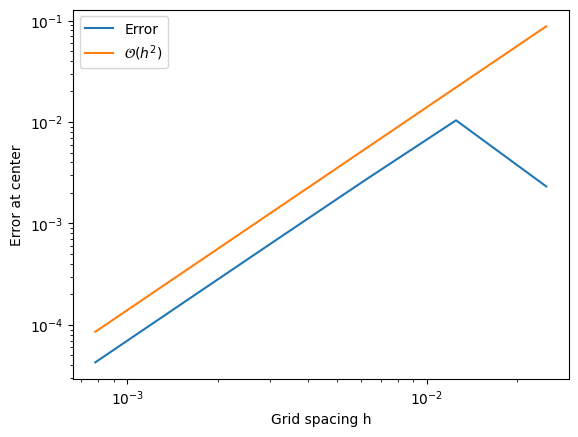

In [52]:
# Plot the experimental order of convergence in a loglog plot
fig, ax = plt.subplots(1, 1)
ax.loglog(hs, errs, label='Error')
ax.loglog(hs, 2*hs**2*errs[-1]/hs[-1]**2, label=r'$\mathcal{O}(h^2)$')
ax.set_xlabel('Grid spacing h')
ax.set_ylabel('Error at center')
ax.legend()
plt.show()

# Task 6
We want to compute the H1 norm of the error $e_h$. This is given by
$$||e_h||^2_{H^1}=\int_{\Omega}(u-u_h)^2dx+\int_{\Omega}\nabla(u-u_h)\cdot\nabla(u-u_h)dx$$
To compute these integrals, we will split the integral into a sum of integrals over each element, then localize the integrals over the reference elements. We need to do this since our basis and $u_h$ are both defined on the local elements. Then we approximate the integrals over each local element by midpoint quadrature again.
As $u_h=\sum_ku_k\hat{\phi}_k(\hat{x})$ on each local element, we have $\nabla u_h=\sum_ku_k\nabla\hat{\phi}_k(\hat{x})$, using gradients of the hat functions computed in the `LinearLagrangeSpace` class.

Our norm is then approximated as
$$||e_h||^2_{H^1}\approx\sum_{\hat{E}_i}[(u(F_E(\hat{S}_{di}))-u_h(\hat{S}_{di}))^2|DF||\hat{E}_i|+(\nabla u(F_E(\hat{S}_{di}))-\nabla u_h(\hat{S}_{di}))\cdot(\nabla u(F_E(\hat{S}_{di}))-\nabla u_h(\hat{S}_{di}))|DF||\hat{E}_{i}|]$$

In [49]:
domain = cartesianDomain([0, 0], [1, 1], [10, 10])
view = aluConformGrid(domain)
# then the grid function to project
@gridFunction(view, name="u_ex", order=3)
def u(p):
    x,y = p
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)
# with gradient
@gridFunction(view, name='grad u', order=1)
def grad_u(p):
    x, y = p
    return np.array([-2*np.pi*np.sin(2*np.pi*x)*np.cos(2*np.pi*y), -2*np.pi*np.cos(2*np.pi*x)*np.sin(2*np.pi*y)])
# and then do the projection on a series of globally refined grids
refs = 6
errs = np.zeros(refs)
err_norms = np.zeros(refs)
hs = np.zeros(refs)
for ref in range(refs):
    space = LinearLagrangeSpace(view)
    print("number of elements:",view.size(0),"number of dofs:",len(space.mapper))
    rhs,matrix = assemble(space, u)
    dofs = scipy.sparse.linalg.spsolve(matrix,rhs)
    @gridFunction(view, name="u_h", order=1)
    def uh(e,x):
        indices = space.mapper(e)
        phiVals = space.evaluateLocal(x)
        localDofs = dofs[indices]
        return np.dot(localDofs, phiVals)
    # with gradient
    @gridFunction(view, name='grad_u_h', order=1)
    def grad_uh(e, x):
        indices = space.mapper(e)
        grad_phi = space.gradientLocal(x)
        localDofs = dofs[indices]
        return np.dot(localDofs, grad_phi)
    # Error grid function
    @gridFunction(view, name='Error at center', order=1)
    def center_error(element, x):
        # For element, get center w_E and compute |u(w_E)-uh(w_E)|
        # Note that u expects global coordinates and uh works with local
        # coordinates inside each reference element
        global_center = element.geometry.center # Global coordinate
        local_center = np.array([1./3, 1./3]) # Center of the reference element
        err = np.abs(u(global_center)-uh(element, local_center))
        return err
    # error H1 norm
    @gridFunction(view, name='Error Norm', order=1)
    def error_norm(element, x):
        # Approximate the H1 norm of the error over this local element
        global_center = element.geometry.center # Global coordinate
        local_center = np.array([1./3, 1./3]) # Center of the reference element
        area = element.geometry.volume
        DF = element.geometry.integrationElement(local_center)
        center_err = u(global_center)-uh(element, local_center)
        fcn_contribution = center_err**2 * DF * area
        # gradient contribution next
        grad_err = grad_u(global_center)-grad_uh(element, local_center)
        grad_contribution = np.dot(grad_err, grad_err) * DF * area
        return fcn_contribution + grad_contribution
    # Get max error
    maxErr = np.max([center_error(E, np.array([0, 0.])) for E in view.elements])
    errs[ref] = maxErr
    # Get H1 norm (sum integral over all elements)
    err_norms[ref] = np.sum([error_norm(E, np.array([0, 0])) for E in view.elements])
    # Get current grid width
    hs[ref] = gridWidth(view)
    view.hierarchicalGrid.globalRefine(2)

number of elements: 200 number of dofs: 121
number of elements: 800 number of dofs: 441
number of elements: 3200 number of dofs: 1681
number of elements: 12800 number of dofs: 6561
number of elements: 51200 number of dofs: 25921
number of elements: 204800 number of dofs: 103041


In [50]:
print(errs)
print(hs)
print(err_norms)

[2.31825427e-03 1.03914334e-02 2.70533004e-03 6.83120279e-04
 1.71205417e-04 4.28279559e-05]
[0.025      0.0125     0.00625    0.003125   0.0015625  0.00078125]
[2.13113796e-01 5.06016355e-02 1.24423750e-02 3.10989500e-03
 7.85055663e-04 2.05770855e-04]


DUNE-INFO: Substituting symbol O from STIXNonUnicode
DUNE-INFO: Substituting symbol O from STIXNonUnicode


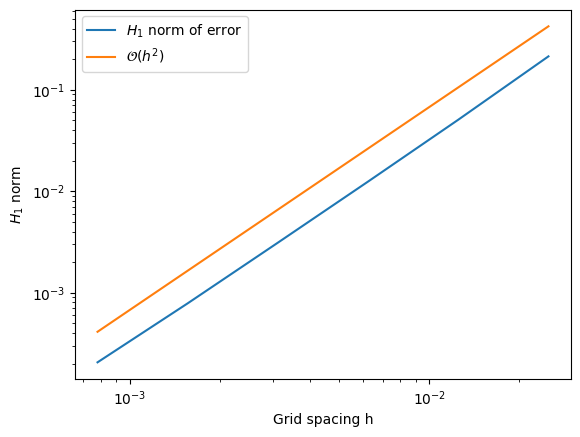

In [55]:
# Plot the experimental order of convergence in a loglog plot
fig, ax = plt.subplots(1, 1)
ax.loglog(hs, err_norms, label=r'$H_1$ norm of error')
ax.loglog(hs, 2*hs**2*err_norms[-1]/hs[-1]**2, label=r"$\mathcal{O}(h^2)$")
ax.set_xlabel('Grid spacing h')
ax.set_ylabel(r'$H_1$ norm')
ax.legend()
plt.show()